In [150]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from src.evals.eval_trees import EvalCntrees

# Load Model

In [151]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "cntree"
wandb_project = "tree_maze"
corr = 0.0
env_name = f"cntree_layers7_bprob0.9_corr{corr}_state_dim10_envs300000_H800_explore"
model_name = "transformer_end_query_embd512_layer3_head4_lr1e-05_drop0_initseed0_batch512_nosched"
#model_name = "transformer_end_query_embd512_layer3_head4_lr1e-05_drop0_batch256"
model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
ckpt_name = find_ckpt_file(model_path, "best")
print(ckpt_name)
path_to_pkl = os.path.join(model_path, ckpt_name)

eval_dset_path = f"/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/cntree/cntree_layers7_bprob1.0_corr{corr}_state_dim10_envs1000_H1600_explore/datasets/eval.pkl"

epoch=48-val_loss=0.000391.ckpt


In [152]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "cntree"
corr = 0.25
env_name = f"cntree_layers7_bprob0.9_corr{corr}_state_dim10_envs300000_H800_explore"
model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0.2_batch256"
model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
ckpt_name = find_ckpt_file(model_path, "best")
print(ckpt_name)
path_to_pkl = os.path.join(model_path, ckpt_name)

eval_dset_path = f"/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/cntree/cntree_layers7_bprob1.0_corr{corr}_state_dim10_envs1000_H1600_explore/datasets/eval.pkl"

epoch=31-val_loss=0.000672.ckpt


In [153]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "train_on_last_pred_only": False,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
    "linear_attention": False,
}

In [154]:
from src.models.transformer_end_query import Transformer
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

/tmp/ipykernel_615885/79273858.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [155]:
n_eval_envs = 50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


In [156]:
i_eval = 3
traj = eval_trajs[i_eval]

In [157]:
env_config = {
    'max_layers': 7,
    'horizon': 1600,
    'branching_prob': 1.0,
    'node_encoding_corr': corr,
    'state_dim': state_dim,
    'initialization_seed': np.array(traj['initialization_seed']).item()
}

In [158]:
env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)


# Run Model

In [159]:
layers = []
positions = []
state_features = []
state_features = list(env.node_map.keys())

for state_feature in state_features:
    layers.append(env.node_map[state_feature].layer)
    positions.append(env.node_map[state_feature].pos)

In [160]:
def run_model(traj, model, state_features, seq_length):
    hidden_states = [[] for _ in range(model.n_layer)]
    
    for state_feature in state_features: 
        batch = {
            'context_states': convert_to_tensor([np.array(traj['context_states'])]),
            'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
            'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
            'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
            'query_states': convert_to_tensor([np.array(state_feature)]),
            }
        batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
        for k in batch.keys():
            if 'context' in k:
                batch[k] = batch[k][:,:seq_length]
            batch[k] = batch[k].to(model.device)
        model.save_activations = True
        with torch.no_grad():
            out = model(batch)
        _hidden_states = model.activations['hidden_states'][1:] # Tuple over layers
        for i_layer in range(model.n_layer):
            hidden_states[i_layer].append(_hidden_states[i_layer])
    return hidden_states

In [161]:
true_dist_matrix = []

for state_feature in state_features:
    _, dist_from_state = env._make_opt_action_dict(state_feature)
    sorted_dist_from_state = []
    for state_feature in state_features:
        sorted_dist_from_state.append(dist_from_state[state_feature])
    true_dist_matrix.append(sorted_dist_from_state)

true_dist_matrix = np.array(true_dist_matrix)
target = 0.8**true_dist_matrix

In [162]:
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()

In [173]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=25, kernel='precomputed')

def classical_mds(D):
    n = D.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n  # Centering matrix
    return -0.5 * H @ (D**2) @ H

# 2. Gaussian (RBF) kernel
def gaussian_kernel(D, sigma=0.5):
    return np.exp(-D**2 / (2 * sigma**2))

# 3. Linear kernel from Euclidean distances
def linear_kernel(D):
    return -0.5 * (D**2)

def negative_distance(D):
    return -D

def power_transform(D, power=2):
    return -(D**power)

gram_matrix = classical_mds(1 - (0.3**true_dist_matrix))
target = kpca.fit_transform(gram_matrix)
target = scaler1.fit_transform(target)

#from sklearn.manifold import MDS
#mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
#distance_embeddings = mds.fit_transform(true_dist_matrix)
#scaler1 = StandardScaler()
#target = scaler1.fit_transform(distance_embeddings)

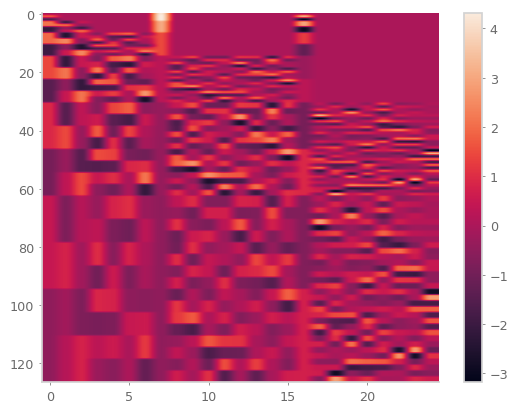

In [174]:
plt.figure()
plt.imshow(target, aspect='auto')
plt.colorbar()
plt.show()

In [175]:
def get_cca_projections(hidden_states, target):
    projections = []
    rotations = []

    train_sample_idxs = np.arange(len(target))
    test_sample_idxs = train_sample_idxs

    #train_sample_idxs = np.arange(0, len(target), step=2)
    #test_sample_idxs = np.setdiff1d(np.arange(len(target)), train_sample_idxs)

    #train_sample_idxs = np.random.choice(len(target), size=int(len(target)*0.75), replace=False)
    #test_sample_idxs = np.setdiff1d(np.arange(len(target)), train_sample_idxs)
    #train_sample_idxs = np.sort(train_sample_idxs)
    #test_sample_idxs = np.sort(test_sample_idxs)

    for layer in range(len(hidden_states)):
        X = torch.stack(hidden_states[layer])
        X = X.detach().cpu().numpy().squeeze()  # (states, sequence length, hidden dim)
        data = X[:, -1, :]  # Response when given last (query) token
        scaler2 = StandardScaler()
        data = scaler2.fit_transform(data)
        
        # Perform CCA between data and true_dist_matrix, using every other row
        cca = CCA(n_components=2)
        cca.fit(data[train_sample_idxs], target[train_sample_idxs])
        train_score = cca.score(data[train_sample_idxs], target[train_sample_idxs])
        test_score = cca.score(data[test_sample_idxs], target[test_sample_idxs])
        print(f'Train Score: {train_score}')
        print(f'Test Score: {test_score}')
        
        # Get first two canonical vectors
        X_c, Y_c = cca.transform(data[test_sample_idxs], target[test_sample_idxs])
        projections.append(X_c)
        rotations.append(cca.x_weights_)
    return projections, rotations, test_sample_idxs

In [176]:
def make_cca_plots(projections, test_sample_idxs):
    n_layers = len(projections)
    fig, axs = plt.subplots(1, n_layers, figsize=(8, 8 * n_layers))
    for layer in range(n_layers):
        _projections = projections[layer]
        axs[layer].scatter(
            _projections[:, 0], _projections[:, 1],
            c=np.array(layers)[test_sample_idxs],
            cmap='plasma', s=25,
            alpha=0.7)
        axs[layer].set_aspect('equal', 'box')
        axs[layer].set_title(f'Layer {layer}')
        axs[layer].set_box_aspect(1)
        # Remove ticks and labels
        axs[layer].set_xticks([])
        axs[layer].set_yticks([])
        # Add box outline on all sides
        for spine in axs[layer].spines.values():
            spine.set_visible(True)
    plt.tight_layout()
    plt.show()


Sequence Length: 1
Train Score: 0.007072795596614018
Test Score: 0.007072795596614018
Train Score: 0.01034136859435478
Test Score: 0.01034136859435478
Train Score: 0.008630067524602167
Test Score: 0.008630067524602167


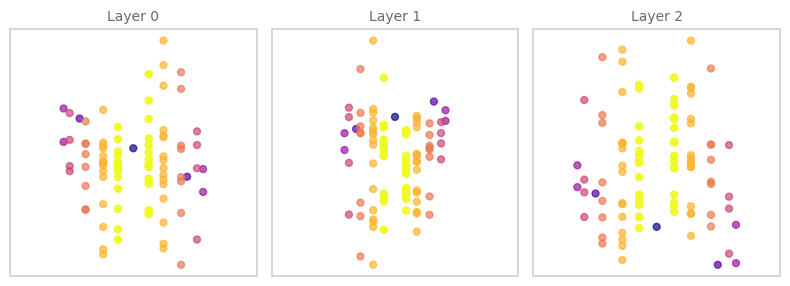

Sequence Length: 1000
Train Score: 0.04321247547154941
Test Score: 0.04321247547154941
Train Score: 0.045604352107826304
Test Score: 0.045604352107826304
Train Score: 0.0468699287032932
Test Score: 0.0468699287032932


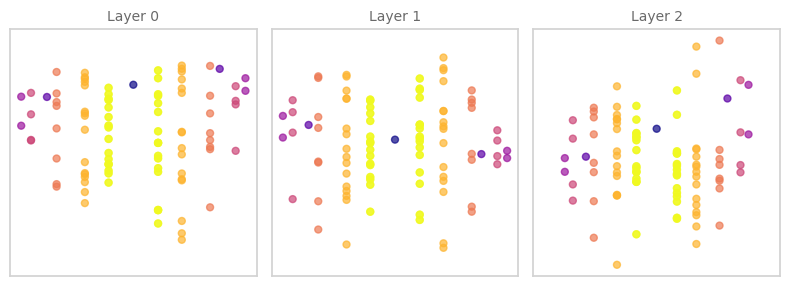

In [177]:
seq_lengths = [1, 1000]
for seq_length in seq_lengths:
    print(f'Sequence Length: {seq_length}')
    hidden_states = run_model(traj, model, state_features, seq_length)
    projections, rotations, test_sample_idxs = get_cca_projections(hidden_states, target)
    make_cca_plots(projections, test_sample_idxs)
    
    # Clear GPU memory
    del hidden_states
    torch.cuda.empty_cache()
